<a href="https://colab.research.google.com/github/JPA-BERT/jpa-bert.github.io/blob/master/notebooks/03PyTorchTEXT_char_rnn_generation_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
    
このファイルは PyTorch のチュートリアルにあるファイル <https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html> を翻訳して，加筆修正したもの
です。

すぐれたチュートリアルの内容，コードを公開された Sean Robertson と PyTorch 開発陣に敬意を表します。

- Original: 
- Date: 2020-0811
- Translated and modified: Shin Asakawa <asakawa@ieee.org>

---

In [1]:
# from https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
%matplotlib inline

# ゼロからの NLP (自然言語処理): 文字レベル RNN による苗字の生成
<!--
# NLP From Scratch: Generating Names with a Character-Level RNN
-->

**Author**: [Sean Robertson](https://github.com/spro/practical-pytorch)

「ゼロからの NLP」の 3 つのチュートリアルの 第2回目です。
[1 回目のチュートリアル](intermediate/char_rnn_classification_tutorial) 
(訳注: この翻訳では <>)
では RNN を使って名前をその言語に分類しました。
今回は裏を返せば，言語から名前を生成します。

<!--
This is our second of three tutorials on "NLP From Scratch". 
In the [first tutorial](intermediate/char_rnn_classification_tutorial), we used a RNN to classify names into their language of origin. 
This time we'll turn around and generate names from languages.
-->

```bash
$ python sample.py Russian RUS
Rovakov
Uantov
Shavakov

$ python sample.py German GER
Gerren
Ereng
Rosher

$ python sample.py Spanish SPA
Salla
Parer
Allan

$ python sample.py Chinese CHI
Chan
Hang
Iun
```

We are still hand-crafting a small RNN with a few linear layers. 
The big difference is instead of predicting a category after reading in all the letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be done with words or other higher order constructs) is often referred to as a "language model".


**推薦図書:**
<!--**Recommended Reading:**-->

<!--I assume you have at least installed PyTorch, know Python, and understand Tensors:-->

このチュートリアルでは，最低限，インストール済 PyTorch，Python を知っていること，Tensors を理解していることを前提としています。

- https://pytorch.org/ インストール方法について<!--For installation instructions-->
- [deep_learning_60min_blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) PyTorch を始めるには <!--to get started with PyTorch in general-->
- [pytorch_with_examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) 広範囲で深い概観 <!--for a wide and deep overview-->
- [former_torchies_tutorial](https://pytorch.org/tutorials/beginner/former_torchies_tutorial.html?highlight=former%20tutorials) Lua ユーザのためのチュートリアル <!--if you are former Lua Torch user-->

リカレントニューラルネットワークとその動作について有益な情報:
<!--It would also be useful to know about RNNs and how they work:-->

-  [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) 有益な事例の例証 <!--shows a bunch of real life examples -->
-  [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) 具体的には LSTM についてですが，一般的には RNN についても参考になります。<!--is about LSTMs specifically but also informative about RNNs in  general-->

## データの準備
<!--
## Preparing the Data
-->

### 覚書:
<!--
### Note:
-->

ここからデータをダウンロードして，カレントディレクトリに解凍してください
<!--
Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract it to the current directory.
-->

``data/names`` ディレクトリは 18 個のテキストファイルがあります。各々 "\[Language\].txt" というファイル名です。
各ファイルは各行に一つ名前が書かれています。順番はランダマイズされていますが，ユニコードをアスキー文字に変換する必要があります。
<!--
Included in the ``data/names`` directory are 18 text files named as "[Language].txt". 
Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).
-->

最終的には言語ごとの名前のリストの辞書 ``{language: [names ...]}`` です。
一般的な変数 "category" と "line"（ここでは言語と名前を表す）は後で必要となる拡張性のためです。
<!--
We'll end up with a dictionary of lists of names per language, ``{language: [names ...]}``. 
The generic variables "category" and "line" (for language and name in our case) are used for later extensibility.
-->


In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip   

In [15]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Portuguese', 'Greek', 'Arabic', 'Korean', 'Italian', 'Scottish', 'Vietnamese', 'Japanese', 'German', 'Russian', 'Polish', 'Czech', 'Irish', 'French', 'Spanish', 'English', 'Dutch', 'Chinese']
O'Neal


## ネットワークの作成

<!--
## Creating the Network
-->

<!--
This network extends [the last tutorial's RNN](Creating-the-Network) with an extra argument for the category tensor, which is concatenated along with the others. 
The category tensor is a one-hot vector just like the letter input.
-->

このネットワークは、[前回のチュートリアルの RNN](Creating-the-Network)を拡張したものです。
カテゴリテンソルのための追加引数を持ち，他の引数と一緒に連結されます。
カテゴリテンソルは，文字入力と同じように 1 つのホットベクトルです。

<!--
We will interpret the output as the probability of the next letter. 
When sampling, the most likely output letter is used as the next input letter.
-->

出力は次の文字の確率として解釈します。
サンプリングの際には，出力される可能性の高い文字を次の入力文字として使用します。

I added a second linear layer ``o2o`` (after combining hidden and output) to give it more muscle to work with. 
There's also a dropout layer, which [randomly zeros parts of its input](https://arxiv.org/abs/1207.0580) with a given probability (here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some chaos and increase sampling variety.

2つ目の線形層 ``o2o`` (hidden と output を組み合わせた後に) を追加して，作業にメリハリをつけるようにしました。
ドロップアウト層もあります。これは [入力の一部をランダムにゼロにする](https://arxiv.org/abs/1207.0580) というものです。
与えられた確率 (ここでは 0.1)で，通常はオーバーフィットを防ぐために入力をファズさせるのに使われます。
ここでは意図的にカオスを加えてサンプリングの多様性を高めるために，ネットワークの最後に使用しています。

<!--
.. figure:: https://i.imgur.com/jzVrf7f.png
   :alt:
-->


<img src="https://i.imgur.com/jzVrf7f.png" style="width:33%">


In [16]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# 訓練
<!--
## Training
-->

## 訓練の準備
<!--
## Preparing for Training
-->

最初に，カテゴリと行のランダム対を得るためのヘルパー関数を定義します:
<!--
First of all, helper functions to get random pairs of (category, line):
-->



In [17]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

<!--
For each timestep (that is, for each letter in a training word) the inputs of the network will be ``(category, current letter, hidden state)`` and the outputs will be ``(next letter, next hidden state)``. So for each training set, we'll need the category, a set of input letters, and a set of output/target letters.
-->

各タイムステップ(つまり学習単語の中の各文字)において，ネットワークの入力は ``(カテゴリ, 現在の文字, 隠れた状態)`` となります。
出力は ``(次の文字, 次の隠れた状態)`` です。
したがって，それぞれの学習セットに対して，カテゴリ，入力文字のセット，出力/ターゲット文字のセットが必要になります。

<!--
Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"), ("C", "D"), ("D", "EOS").
-->

各タイムステップで現在の文字から次の文字を予測しているので，文字ペアはその行の連続した文字のグループになります - 例えば，"ABCD<EOS>" の場合 ("A", "B"), ("B", "C"), ("C", "D"), ("D", "EOS")となります。


<!--
.. figure:: https://i.imgur.com/JH58tXY.png
   :alt:
-->

<img src="https://i.imgur.com/JH58tXY.png" style="width:66%">

<!--
The category tensor is a [one-hot tensor](https://en.wikipedia.org/wiki/One-hot) of size ``<1 x n_categories>``. 
When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.
-->
    
カテゴリテンソルはサイズ ``[1 x n_categories]``  の [ワンホットテンソル](https://en.wikipedia.org/wiki/One-hot) です。
これは設計上の選択であり，初期の隠れ層や他の戦略の一部として含まれている可能性があります。



In [18]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

<!--
For convenience during training we'll make a ``randomTrainingExample`` function that fetches a random (category, line) pair and turns them into the required (category, input, target) tensors.
-->

学習中に便利なように ``randomTrainingExample`` 関数を作ってみましょう。
訓練中にランダムな (カテゴリと行との)対を取得し，それを必要な(カテゴリ, 入力, 目標) テンソルに変換する簡単な ``randomTrainingExample`` 関数を作ってみましょう。


In [19]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## ネットワークを訓練する
<!--
## Training the Network
-->

<!--
In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end.
-->

最後の出力だけを使う分類とは違い，ステップごとに予測をしているのでステップごとに損失を計算しています。

自動微分のマジックを使えば，これらの損失を各ステップで単純に合計して，最後に逆算して呼び出すことができます。


In [20]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

<!--
To keep track of how long training takes I am adding a ``timeSince(timestamp)`` function which returns a human readable string:
-->

訓練に要した時間を記録するため，人間が読める文字列を返す ``timeSince(timestamp)`` 関数を追加しています。


In [21]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

<!--
Training is business as usual - call train a bunch of times and wait a few minutes, printing the current time and loss every ``print_every`` examples, and keeping store of an average loss per ``plot_every`` examples in ``all_losses`` for plotting later.
-->

訓練はいつものように行います。
`train` を何度も呼び出して数分待ち，現在の時間と損失を `print_every` の例ごとに表示します。
後でプロットするために `plot_every` の例ごとの平均損失を `all_losses` の中に保存します。



In [22]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 14s (5000 5%) 2.8376
0m 28s (10000 10%) 2.6974
0m 42s (15000 15%) 3.0707
0m 57s (20000 20%) 2.6628
1m 11s (25000 25%) 2.9733
1m 26s (30000 30%) 3.0265
1m 40s (35000 35%) 2.4190
1m 55s (40000 40%) 1.9681
2m 9s (45000 45%) 2.0322
2m 24s (50000 50%) 2.2317
2m 38s (55000 55%) 1.9612
2m 52s (60000 60%) 2.3128
3m 7s (65000 65%) 2.5840
3m 21s (70000 70%) 1.2222
3m 35s (75000 75%) 2.0350
3m 49s (80000 80%) 3.4048
4m 4s (85000 85%) 2.0767
4m 18s (90000 90%) 1.9382
4m 32s (95000 95%) 3.5228
4m 47s (100000 100%) 1.6025


## 損失関数のプロット
<!--
## Plotting the Losses
-->

<!--Plotting the historical loss from all\_losses shows the network learning:-->

すべての損失から損失値の履歴をプロットすると ネットワークの学習過程を示します:



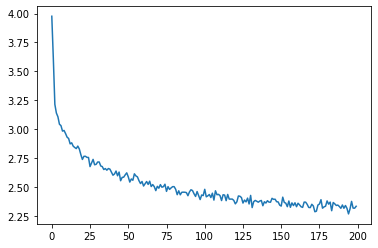

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## ネットワークのサンプリング
<!--
## Sampling the Network
-->

<!--
To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.
-->

<!--サンプルとして-->
ネットワークに文字を与え，次の文字は何かを尋ね，それを次の文字として入力し，EOSトークンまで繰り返します。

```
- 入力カテゴリ，開始文字，ゼロで初期化した中間層テンソルを作成する
- 文字列 ``output_name`` を作成する
- 最大出力長まで以下を繰り返す
    - 現在の文字をネットワークに送る
    - 最高出力値から次の文字を出力し，次の中間層態を取得する
    - 文字が EOS の場合はここで中止する
    - 通常の文字の場合は ``output_name`` に追加して次のステップを続ける
- 最終的な名前を返す
```

<!--
- Create tensors for input category, starting letter, and empty hidden state
- Create a string ``output_name`` with the starting letter
- Up to a maximum output length,
    - Feed the current letter to the network
    - Get the next letter from highest output, and next hidden state
    - If the letter is EOS, stop here
    - If a regular letter, add to ``output_name`` and continue
- Return the final name
-->

### 覚書:

開始文字を与えるのではなく，別の戦略として，学習時に「文字列の開始」トークンを含め，ネットワークに独自の開始文字を選択させるという方法もあったでしょう。

<!--
.. Note::
Rather than having to give it a starting letter, another strategy would have been to include a "start of string" token in training and have the network choose its own starting letter.
-->


In [24]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))


print('ロシア人')
samples('Russian', 'RUS')

print('\nドイツ人')
samples('German', 'GER')

print('\nスペイン人')
samples('Spanish', 'SPA')

print('\n中国人')
samples('Chinese', 'CHI')

print('\n日本人')
samples('Japanese', 'JPA')

ロシア人
Rovakov
Uoverin
Shilovev

ドイツ人
Gerren
Erent
Roull

スペイン人
Salla
Parer
Allara

中国人
Chan
Han
Iun

日本人
Jamas
Pamara
Araki


## 演習
<!--
## Exercises

- Try with a different dataset of category -> line, for example:
    - Fictional series -> Character name
    - Part of speech -> Word
    - Country -> City

- Use a "start of sentence" token so that sampling can be done without choosing a start letter
- Get better results with a bigger and/or better shaped network
    - Try the nn.LSTM and nn.GRU layers
    - Combine multiple of these RNNs as a higher level network
-->

- カテゴリ -> セリフなど 別のデータセットで試してみよ
    - 虚構シリーズ -> キャラクター名
    - 品詞 -> 単語
    - 国 -> 都市

- 文頭文字を選択しなくてもサンプリングができるように、「文頭」トークンを使用する
- より大きなネットワークとより良い形のネットワークで より良い結果を得ることができる
    - nn.LSTM と nn.GRU レイヤーを試せ
    - これらの複数の RNN を高次ネットワークとして組み合わよ
